# Uniform angles vs. Uniform quaternions Data Generation

In [2]:
import numpy as np
import random
import os, sys
import scipy.io as sio
sys.path.append("../..")
import time
import mrcfile
import skimage
from skimage import transform
import matplotlib.pyplot as plt
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler


def project_volume(Vol, Angles, Vol_geom, ProjSize):
    # Generate orientation vectors based on angles
    Orientation_Vectors   = RotationMatrix(Angles)

    # Create projection 2D geometry in ASTRA
    Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors)

    # Generate projs 
    _, Proj_data = astra.create_sino3d_gpu(Vol, Proj_geom, Vol_geom)

    # Reshape projections correctly 
    Projections = np.transpose(Proj_data, (1, 0, 2))

    return  Projections	


def gen_projs_ASTRA(Vol, AngCoverage, AngShift, ProjSize, BatchSizeAstra, angles_gen_type="uniform_angles"):
    """
    angles_gen_type: str
        Takes values in [`uniform_angles`, `uniform_quaternions`]
    """
    # Create 3D geometry in ASTRA
    Vol_geom    = astra.create_vol_geom(Vol.shape[1], Vol.shape[2], Vol.shape[0])

    # Generate random angles
    if angles_gen_type == "uniform_angles":
        Z1 =  AngShift[0]*np.pi + AngCoverage[0]*np.pi*np.random.random(size=(BatchSizeAstra, 1))
        Y2 =  AngShift[1]*np.pi + AngCoverage[1]*np.pi*np.random.random(size=(BatchSizeAstra, 1))
        Z3 =  AngShift[2]*np.pi + AngCoverage[2]*np.pi*np.random.random(size=(BatchSizeAstra, 1))
        angles = np.concatenate((Z1, Y2, Z3), axis=1)
    elif angles_gen_type == "uniform_S3":
        quaternions = quaternion.normalized_random_uniform(quaternion_shape=(BatchSizeAstra,))
        quaternions = quaternions  #[:BatchSizeAstra]
        angles = quaternion2euler(quaternions)
        
#         indices = np.where((AngShift[0]*np.pi<=angles[:,0]) & (angles[:,0]<=AngCoverage[0]*np.pi) & ((AngShift[1]*np.pi<=angles[:,1]) & (angles[:,1]<=AngCoverage[1]*np.pi) & (AngShift[2]*np.pi<=angles[:,2]) & (angles[:,2]<=AngCoverage[2]*np.pi)))[0]
#         angles = np.take(angles, indices, axis=0)

#         phi = 2*np.pi*np.random.random(size=(BatchSizeAstra, 1))
#         cos_theta = 2*np.random.random(size=(BatchSizeAstra, 1))-1
#         u = np.random.random(size=(BatchSizeAstra, 1))
#         theta = np.arccos(cos_theta)
#         r = np.cbrt(u)

#         phi = AngShift[2]*np.pi + AngCoverage[2]**np.pi*np.random.random(size=(BatchSizeAstra, 1))
#         min_v = min(np.cos(AngShift[1]*np.pi), np.cos(AngShift[1]*np.pi+AngCoverage[1]*np.pi))
#         max_v = max(np.cos(AngShift[1]*np.pi), np.cos(AngShift[1]*np.pi+AngCoverage[1]*np.pi))
#         cos_theta = np.random.uniform(low=min_v, high=max_v, size=(BatchSizeAstra, 1))
#         u = np.random.random(size=(BatchSizeAstra, 1))
#         theta = np.arccos(cos_theta)
#         # TODO: left to limit r
#         r = np.cbrt(u)
#         angles = np.concatenate((r, theta, phi), axis=1)
    else:
        raise NotImplemented("Please specify angles_gen_type parameter that represents how angles will be generated")
    
    # Generate projections
    Projections = project_volume(Vol, angles, Vol_geom, ProjSize)

    return Projections, angles

def generate_2D_projections(input_file_path, ProjNber, AngCoverage, AngShift, angles_gen_type=None, output_file_name=None):
    """
    input_file_path: str
        Full path to the *.mrc file with 3D volume
    ProjNber: int
        Number of 2D projections 
    AngCoverage: list
        list of max values for each axis. E.g. `0.5,0.5,2.0` means it: x axis angle and y axis angle take values in range [0, 0.5*pi], z axis angles in range [0, 2.0*pi]
    AngShift: list
        Start of angular coverage
    output_file_name: str
        Just the name of the output *.mat file. 
        If not specified, it will be generated automatically.
    """
    # nber of projs created in a single ASTRA loop
    BatchSizeAstra = 50 

    # filepaths 
    protein_name = input_file_path.split('/')[-1].split('.')[0]
    coverage_str = str(AngCoverage).replace(" ", "")[1:-1]
    shift_str    = str(AngShift).replace(" ", "")[1:-1]
    output_file_name = output_file_name or f'{protein_name}_ProjectionsAngles_ProjNber{ProjNber}_AngCoverage{coverage_str}_AngShift{shift_str}.h5'
    # get file extension
    extension = output_file_name.split('.')[-1]
    # storing output where the input mrc file is
    proj_ang_path = os.path.join(os.path.dirname(input_file_path), output_file_name)

    # loads data if data already exists 
    if os.path.exists(proj_ang_path):
        print('* Loading the dataset *\n')

        # read from the file
        if extension == "h5":
            with h5py.File(proj_ang_path, 'r') as data:
                Projections = np.float32(data['Projections'])
                Angles      = np.float32(data['Angles'])
        elif extension == "mat":
            with sio.loadmat(proj_ang_path) as data:
                Projections = np.float32(data['Projections'])
                Angles      = np.float32(data['Angles'])
        else: 
            raise NotImplementedError(f"Extension {extension} is not implemented")
    # generate data if data doesn't exist  
    else:
        print('* Generating the dataset *\n')

        # Load 3D volume
        # Value error fix explained here: https://mrcfile.readthedocs.io/en/latest/usage_guide.html 
        try:
            with mrcfile.open(input_file_path) as mrcVol:
                Vol      = np.array(mrcVol.data) 
                ProjSize = int(np.sqrt(np.sum(np.square(Vol.shape))))
        except ValueError:
            with mrcfile.open(input_file_path, mode='r+', permissive=True) as mrcVol:
                mrcVol.header.map = mrcfile.constants.MAP_ID
                Vol      = np.array(mrcVol.data) 
                ProjSize = int(np.sqrt(np.sum(np.square(Vol.shape))))

        # Initialisations 
        Projections = np.zeros((ProjNber, ProjSize, ProjSize), dtype=float)
        Angles      = np.zeros((ProjNber, 3), dtype=float)

        # Generate projs with ASTRA by batches 
        Iter = int(ProjNber/BatchSizeAstra) 
        for i in range(Iter):

            # Generate projections 
            projections, angles = gen_projs_ASTRA(Vol, AngCoverage, AngShift, ProjSize, BatchSizeAstra, angles_gen_type)

            # Concatenate generated projections 
            Projections[i*BatchSizeAstra : (i + 1)*BatchSizeAstra, :, :] = projections
            Angles[i*BatchSizeAstra : (i + 1)*BatchSizeAstra, :] = angles  

        # Save data 
        if extension == "h5":
            with h5py.File(proj_ang_path, 'w') as hf:
                hf.create_dataset('Projections', data=Projections)
                hf.create_dataset('Angles', data=Angles)
        elif extension == "mat":
            sio.savemat(proj_ang_path, {'Projections': Projections, 
                                        'Angles': Angles}) 
        else:
            raise NotImplementedError(f"Extension {extension} is not implemented")

    print(f'Projections: {Projections.shape}')
    print(f'Angles: {Angles.shape}\n')

In [3]:
input_file_path = "../../data/5j0n.mrc"
ProjNber = 5000
AngCoverage = [2.0, 1.0, 2.0]
AngShift = [0, 0, 0]
output_file_name = "/mnt/scratch/students/5j0n_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

generate_2D_projections(input_file_path=input_file_path, 
                        ProjNber=ProjNber,
                        AngCoverage=AngCoverage,
                        AngShift=AngShift,
                        angles_gen_type="uniform_S3",
                        output_file_name=output_file_name)

* Loading the dataset *

Projections: (5000, 116, 116)
Angles: (5000, 3)



In [6]:
PROTEIN = "5j0n"

# Not Uniform Data Generation

In [19]:
from cryoem.plots import plot_euclidean_space
import ipyvolume as ipv

In [42]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


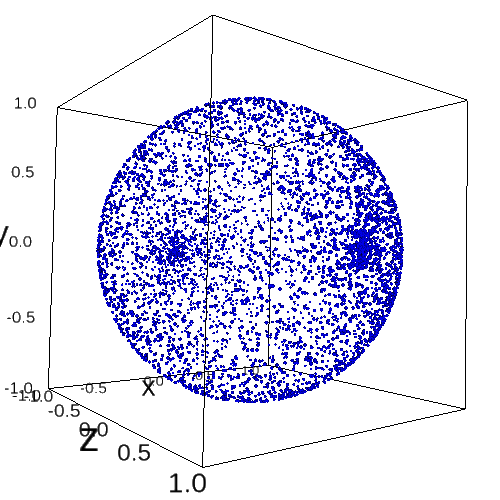

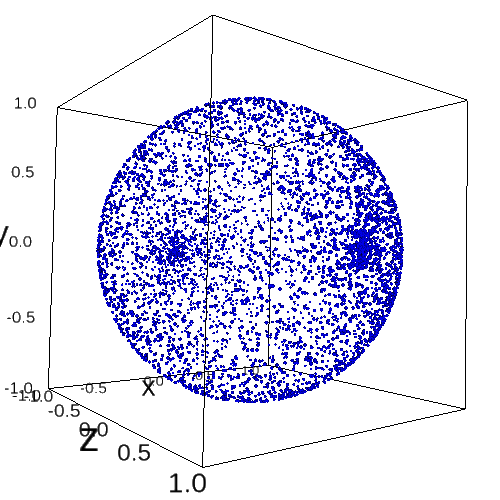

In [43]:
plot_euclidean_space(data['Angles'])

In [44]:
ipv.screenshot()

Output()

# Uniform Data Generation

In [7]:
from cryoem.plots import plot_euclidean_space
import ipyvolume as ipv

In [8]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [10]:
from cryoem.conversions import euler2quaternion

In [11]:
angles_true = data['Angles']
q_true = euler2quaternion(angles_true)

In [13]:
q_true.shape

TensorShape([5000, 4])

(array([262., 462., 552., 594., 623., 618., 625., 560., 435., 269.]),
 array([-0.99639468, -0.79748662, -0.59857856, -0.39967051, -0.20076245,
        -0.00185439,  0.19705366,  0.39596172,  0.59486978,  0.79377783,
         0.99268589]),
 <a list of 10 Patch objects>)

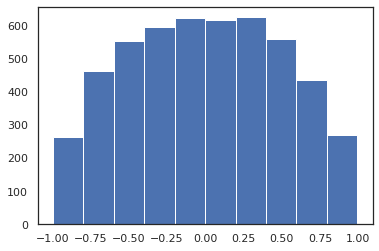

In [14]:
plt.hist(q_true[:,0])

(array([244., 452., 627., 584., 616., 576., 626., 555., 464., 256.]),
 array([-0.99914839, -0.79980999, -0.60047159, -0.40113318, -0.20179478,
        -0.00245638,  0.19688202,  0.39622043,  0.59555883,  0.79489723,
         0.99423564]),
 <a list of 10 Patch objects>)

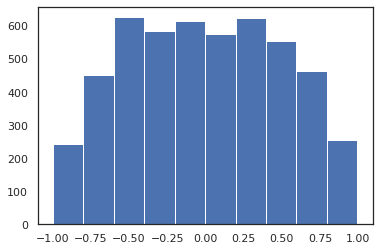

In [15]:
plt.hist(q_true[:,1])

(array([280., 427., 582., 597., 632., 619., 619., 529., 459., 256.]),
 array([-0.99580107, -0.79640101, -0.59700094, -0.39760088, -0.19820081,
         0.00119925,  0.20059932,  0.39999938,  0.59939945,  0.79879951,
         0.99819958]),
 <a list of 10 Patch objects>)

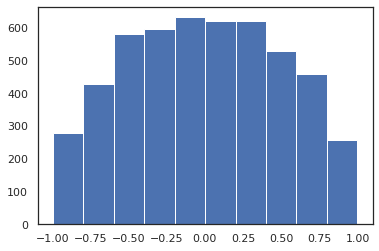

In [16]:
plt.hist(q_true[:,2])

(array([628., 641., 604., 572., 562., 532., 545., 408., 336., 172.]),
 array([1.17721686e-04, 1.00038871e-01, 1.99960020e-01, 2.99881169e-01,
        3.99802318e-01, 4.99723467e-01, 5.99644616e-01, 6.99565765e-01,
        7.99486914e-01, 8.99408063e-01, 9.99329211e-01]),
 <a list of 10 Patch objects>)

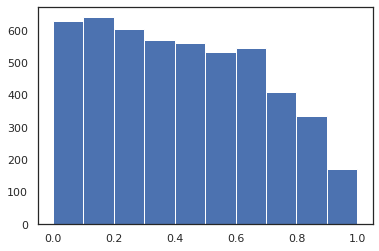

In [17]:
plt.hist(q_true[:,3])

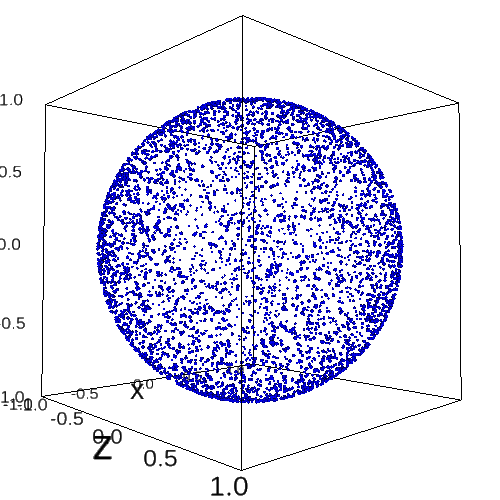

In [47]:
plot_euclidean_space(data['Angles'])

In [48]:
ipv.screenshot()

Output()